In [41]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import numpy as np

In [42]:
file = "results.csv"
sep = ","
enc = "utf-8"

df = pd.read_csv(file, sep=sep, header=0, encoding=enc)

In [43]:
gt_df = pd.read_csv("number_gtos.csv", sep=" ", encoding=enc)
gt_df.columns = ["id", "|Omega|"]

In [44]:
knns = [30, 60]
reg_strengths = [0.0001, 0.01]

cp_args = list(itertools.product(*[reg_strengths, knns]))
n_cp_args = len(cp_args)

stat_cols = [
        "|V|", # nr of vertices
        "|T|", # nr of triangles
        "|S_M|", # nr of superpoints in the mesh partition
        "|E_M|", # nr of superedges in the mesh superpoint graph
        "OOA_M", # overall object accuracy of the mesh
        "|S_M_k|", # nr of superpoints in the mesh partition
        "|E_M_k|", # nr of superedges in the mesh superpoint graph
        "OOA_M_k", # overall object accuracy of the mesh
        "|S_M_ks|", # nr of superpoints in the mesh partition
        "|E_M_ks|", # nr of superedges in the mesh superpoint graph
        "OOA_M_ks", # overall object accuracy of the mesh
        "|S_P|", # nr of superpoints in the point cloud partition
        "|E_P|", # nr of superedges in the point cloud superpoint graph
        "OOA_P", # overall object accuracy of the point cloud
        "mean(n)", # average number of neighbours per vertex
        "std(n)", # std of neighbours per vertex
        "median(n)", # median of neighbours per vertex
        "|Omega|", # number of ground truth objects
        ]

ite_vars = ["s1", # saturation in cp-iteration 1 
    "s2", "s3", "s4", "s5",
    "e1_1", # first error term in cp-iteration 1
    "e1_2", "e1_3", "e1_4", "e1_5",
    "e2_1", # second error term in cp-iteration 1
    "e2_2", "e2_3", "e2_4", "e2_5"]

for post in ["_M", "_M_k", "_M_ks", "_P"]:
    for ite_var in ite_vars:
        stat_cols.append(ite_var + post)

# add ratio column
def get_ratio(stat_df, col_sp, col_ooa):
    l1 = stat_df.loc[:, col_sp] / stat_df.loc[:, "|Omega|"]
    l2 = stat_df.loc[:, "|Omega|"] / stat_df.loc[:, col_sp]
    L = pd.concat((l1, l2), axis=1).max(axis=1)
    r = stat_df.loc[:, col_ooa] / L
    return r

stats_list = n_cp_args * [None]
for i in range(n_cp_args):
    reg_strength, knn = cp_args[i]
    tmp_df = df[(df["lambda"] == reg_strength) & (df["knn"] == knn)]
    
    tmp_df = pd.merge(tmp_df, gt_df, how ="inner", on =["id"])
    
    stat_df = tmp_df.loc[:, stat_cols]
    
    ratio_M = get_ratio(stat_df=stat_df, col_sp="|S_M|", col_ooa="OOA_M")
    ratio_M_k = get_ratio(stat_df=stat_df, col_sp="|S_M_k|", col_ooa="OOA_M_k")  
    ratio_M_ks = get_ratio(stat_df=stat_df, col_sp="|S_M_ks|", col_ooa="OOA_M_ks")  
    ratio_P = get_ratio(stat_df=stat_df, col_sp="|S_P|", col_ooa="OOA_P")    
    
    rf = pd.DataFrame(data=[ratio_M, ratio_P, ratio_M_k, ratio_M_ks]).transpose()
    rf.columns = ["r_M", "r_P", "r_M_k", "r_M_ks"]
    
    stat_df_ = pd.concat([stat_df, rf], axis=1)
    
    mean_stat = stat_df_.mean(axis=0)
    std_stat = stat_df_.std(axis=0)
    median_stat = stat_df_.median(axis=0)
    
    stats = pd.concat([mean_stat, std_stat, median_stat], axis=1).transpose()
    #index_str = "_{0:.3f}_{1}".format(reg_strength, knn)
    #stats.index = ["mean" + index_str, "std" + index_str, "median" + index_str]
    stats.index = ["mean", "std", "median"]
    stats_t = ((reg_strength, knn), stats)
    stats_list[i] = stats_t

In [45]:
x = np.arange(n_cp_args, dtype=np.uint32)

In [46]:
# we create a list for each plot
rs_list = n_cp_args * [None]
s_list = n_cp_args * [None]
ooa_list = n_cp_args * [None]
params_list = n_cp_args * [None]

s2_list = n_cp_args * [None]
s3_list = n_cp_args * [None]
s4_list = n_cp_args * [None]
s5_list = n_cp_args * [None]

e1_1_list = n_cp_args * [None]
e1_2_list = n_cp_args * [None]
e1_3_list = n_cp_args * [None]
e1_4_list = n_cp_args * [None]
e1_5_list = n_cp_args * [None]

e2_1_list = n_cp_args * [None]
e2_2_list = n_cp_args * [None]
e2_3_list = n_cp_args * [None]
e2_4_list = n_cp_args * [None]
e2_5_list = n_cp_args * [None]

for i in range(n_cp_args):
    stats_t = stats_list[i]
    params = stats_t[0]
    stats = stats_t[1]
    param_str = "{0:.4f},{1}".format(params[0], params[1])
    params_list[i] = param_str
    r_stats = stats.loc["mean", ["r_M", "r_P", "r_M_k", "r_M_ks"]]
    rs = r_stats.to_list()
    rs_list[i] = rs
    s = stats.loc["mean", ["|S_M|", "|S_P|", "|S_M_k|", "|S_M_ks|"]]
    s_list[i] = s
    ooa = stats.loc["mean", ["OOA_M", "OOA_P", "OOA_M_k", "OOA_M_ks"]]
    ooa_list[i] = ooa
    
    s2f = stats.loc["mean", ["s2_M", "s2_P", "s2_M_k", "s2_M_ks"]]
    s2_list[i] = s2f
    s3f = stats.loc["mean", ["s3_M", "s3_P", "s3_M_k", "s3_M_ks"]]
    s3_list[i] = s3f
    s4f = stats.loc["mean", ["s4_M", "s4_P", "s4_M_k", "s4_M_ks"]]
    s4_list[i] = s4f
    s5f = stats.loc["mean", ["s5_M", "s5_P", "s5_M_k", "s5_M_ks"]]
    s5_list[i] = s5f
    
    e1_1f = stats.loc["mean", ["e1_1_M", "e1_1_P", "e1_1_M_k", "e1_1_M_ks"]]
    e1_1_list[i] = e1_1f
    e1_2f = stats.loc["mean", ["e1_2_M", "e1_2_P", "e1_2_M_k", "e1_2_M_ks"]]
    e1_2_list[i] = e1_2f
    e1_3f = stats.loc["mean", ["e1_3_M", "e1_3_P", "e1_3_M_k", "e1_3_M_ks"]]
    e1_3_list[i] = e1_3f
    e1_4f = stats.loc["mean", ["e1_4_M", "e1_4_P", "e1_4_M_k", "e1_4_M_ks"]]
    e1_4_list[i] = e1_4f
    e1_5f = stats.loc["mean", ["e1_5_M", "e1_5_P", "e1_5_M_k", "e1_5_M_ks"]]
    e1_5_list[i] = e1_5f
    
    e2_1f = stats.loc["mean", ["e2_1_M", "e2_1_P", "e2_1_M_k", "e2_1_M_ks"]]
    e2_1_list[i] = e2_1f
    e2_2f = stats.loc["mean", ["e2_2_M", "e2_2_P", "e2_2_M_k", "e2_2_M_ks"]]
    e2_2_list[i] = e2_2f
    e2_3f = stats.loc["mean", ["e2_3_M", "e2_3_P", "e2_3_M_k", "e2_3_M_ks"]]
    e2_3_list[i] = e2_3f
    e2_4f = stats.loc["mean", ["e2_4_M", "e2_4_P", "e2_4_M_k", "e2_4_M_ks"]]
    e2_4_list[i] = e2_4f
    e2_5f = stats.loc["mean", ["e2_5_M", "e2_5_P", "e2_5_M_k", "e2_5_M_ks"]]
    e2_5_list[i] = e2_5f
    
ratios = np.array(rs_list)
sizes = np.array(s_list)
log_sizes = np.log10(sizes)
ooas = np.array(ooa_list)

s2s = np.array(s2_list)
s3s = np.array(s3_list)
s4s = np.array(s4_list)
s5s = np.array(s5_list)

e1_1s = np.array(e1_1_list)
e1_2s = np.array(e1_2_list)
e1_3s = np.array(e1_3_list)
e1_4s = np.array(e1_4_list)
e1_5s = np.array(e1_5_list)

e2_1s = np.array(e2_1_list)
e2_2s = np.array(e2_2_list)
e2_3s = np.array(e2_3_list)
e2_4s = np.array(e2_4_list)
e2_5s = np.array(e2_5_list)

In [47]:
def plot(x, y, ylabel, labels, xticks, title):
    f = plt.figure()
    f.set_figwidth(12)
    f.set_figheight(8)
    plt.rc("font", size=20)
    for i in range(y.shape[1]):
        plt.plot(x, y[:, i], "--x", label=labels[i])
    plt.legend()
    plt.xticks(x, xticks, rotation="vertical")
    #plt.title(title)
    plt.ylabel(ylabel)

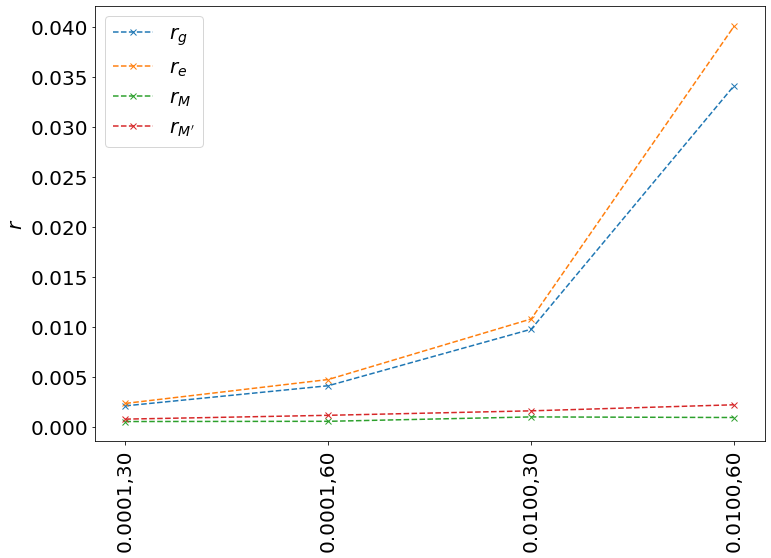

In [48]:
plot(x=x, y=ratios, ylabel=r"$r$", labels=[r"$r_g$", r"$r_e$", r"$r_M$", r"$r_{M^\prime}$"], xticks=params_list, title=r"ratio $r$")
plt.savefig("ratio.png", bbox_inches="tight")

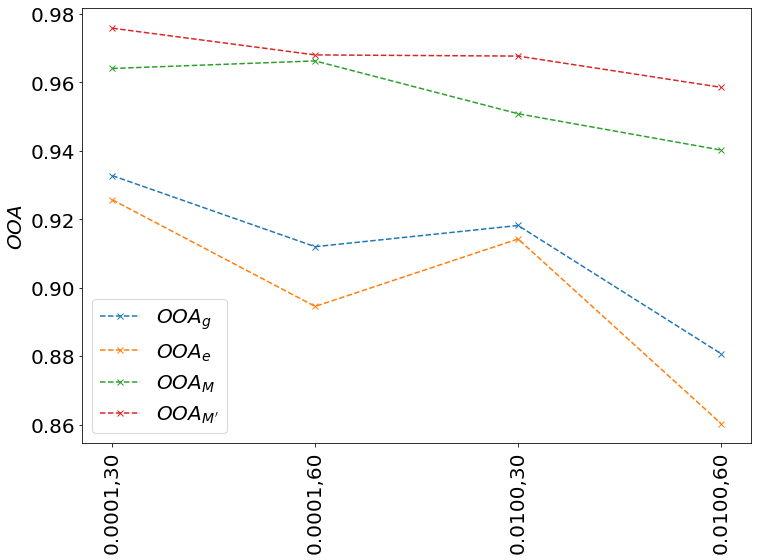

In [49]:
plot(x=x, y=ooas, ylabel=r"$OOA$", labels=[r"$OOA_g$", r"$OOA_e$", r"$OOA_{M}$", r"$OOA_{M^\prime}$"],
     xticks=params_list, title=r"Overall Object Accuracy ($OOA$)")
plt.savefig("ooa.png", bbox_inches="tight")

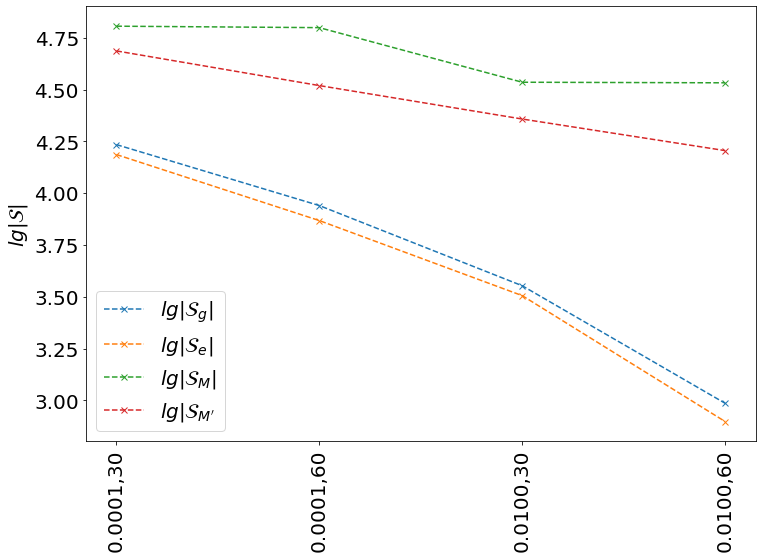

In [50]:
plot(x=x, y=log_sizes, ylabel=r"$lg|\mathcal{S}|$",
     labels=[r"$lg|\mathcal{S}_g|$", r"$lg|\mathcal{S}_e|$", r"$lg|\mathcal{S}_{M}|$", r"$lg|\mathcal{S}_{M^\prime}$"],
     xticks=params_list, title=r"log of the partition sizes $lg|\mathcal{S}|$")
plt.savefig("log_sizes.png", bbox_inches="tight")

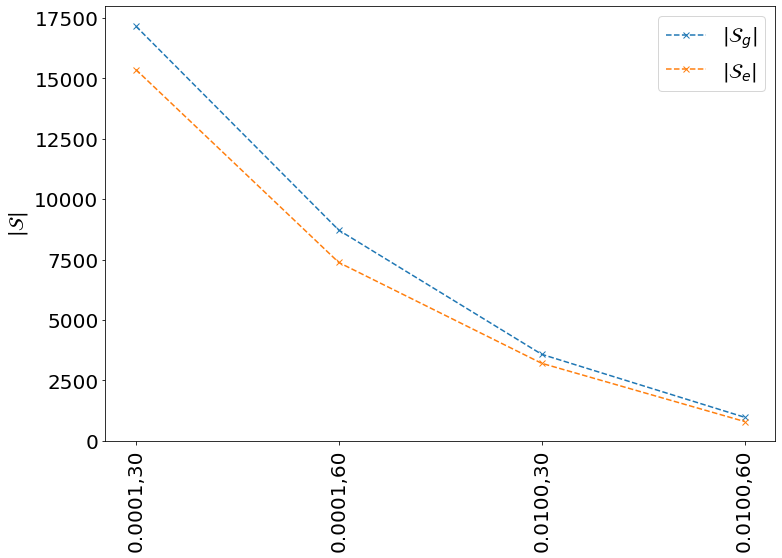

In [51]:
plot(x=x, y=sizes[:, :2], ylabel=r"$|\mathcal{S}|$", labels=[r"$|\mathcal{S}_g|$", r"$|\mathcal{S}_e|$"],
     xticks=params_list, title=r"$|\mathcal{S}|$")

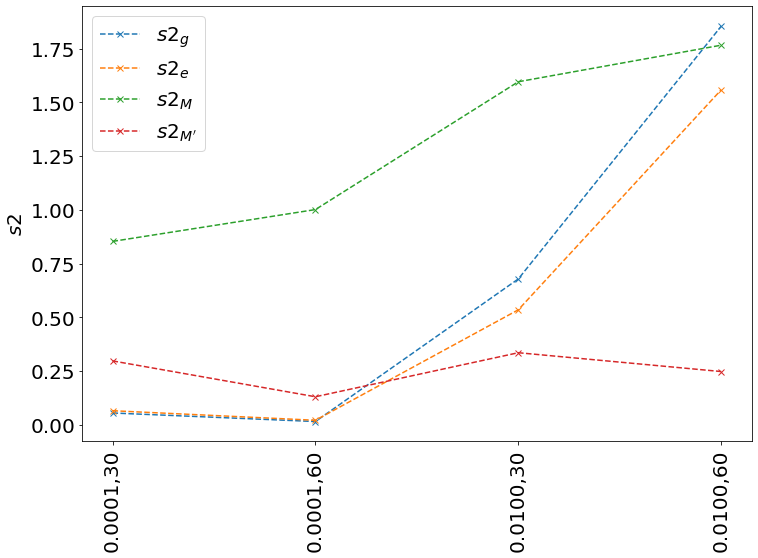

In [52]:
plot(x=x, y=s2s, ylabel=r"$s2$",
     labels=[r"$s2_g$", r"$s2_e$", r"$s2_{M}$", r"$s2_{M^\prime}$"],
     xticks=params_list, title=r"$Saturation in main iteration 2$")

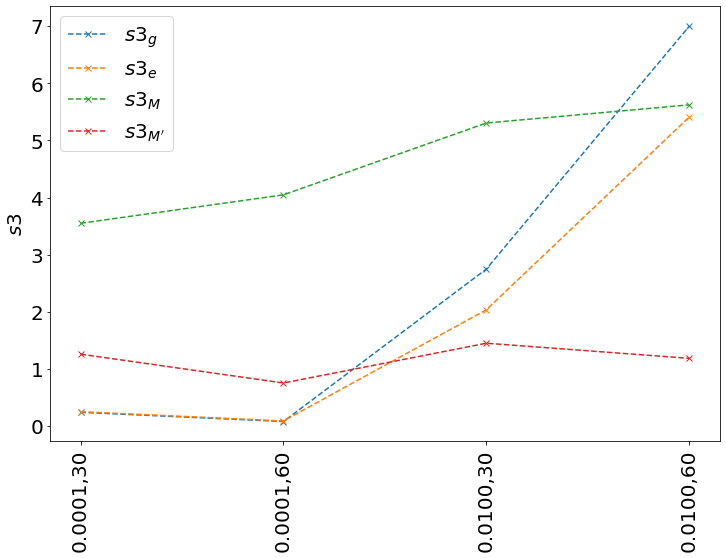

In [53]:
plot(x=x, y=s3s, ylabel=r"$s3$",
     labels=[r"$s3_g$", r"$s3_e$", r"$s3_{M}$", r"$s3_{M^\prime}$"],
     xticks=params_list, title=r"$Saturation in main iteration 3$")

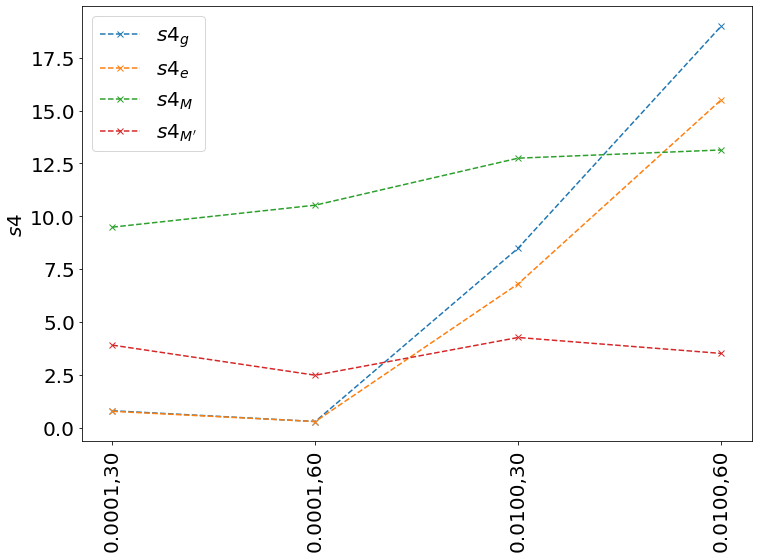

In [54]:
plot(x=x, y=s4s, ylabel=r"$s4$",
     labels=[r"$s4_g$", r"$s4_e$", r"$s4_{M}$", r"$s4_{M^\prime}$"],
     xticks=params_list, title=r"$Saturation in main iteration 4$")

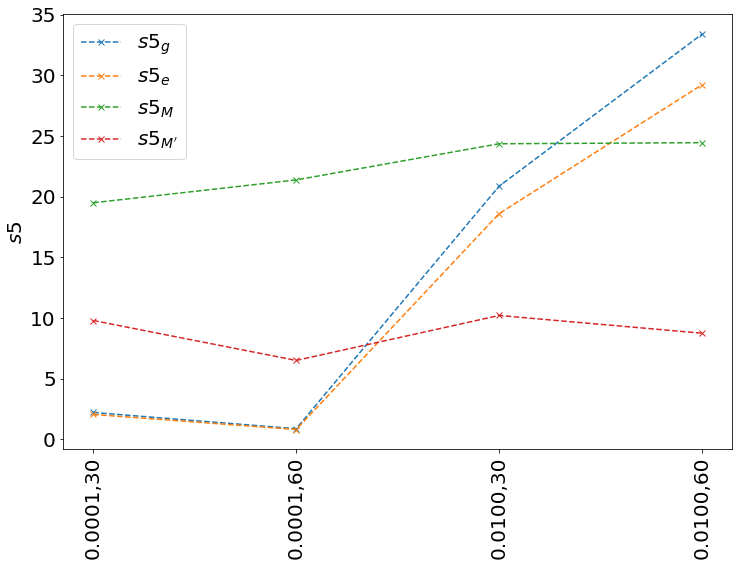

In [55]:
plot(x=x, y=s5s, ylabel=r"$s5$",
     labels=[r"$s5_g$", r"$s5_e$", r"$s5_{M}$", r"$s5_{M^\prime}$"],
     xticks=params_list, title=r"$Saturation in main iteration 5$")

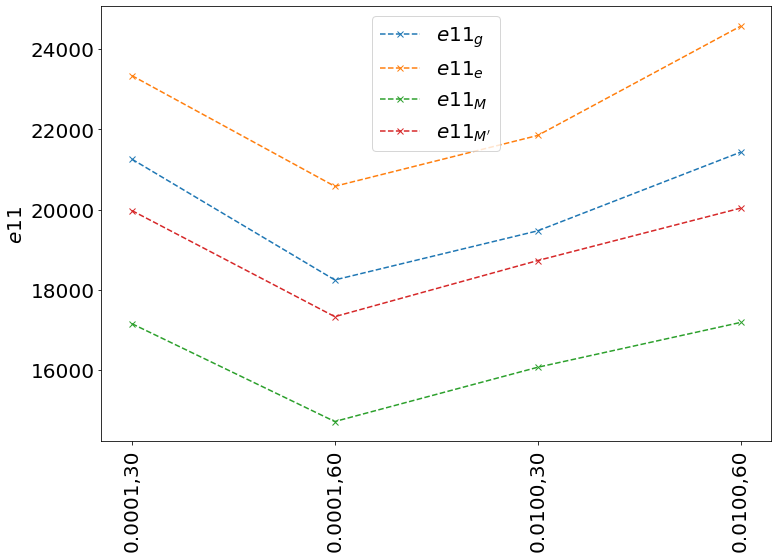

In [56]:
plot(x=x, y=e1_1s, ylabel=r"$e11$",
     labels=[r"$e11_g$", r"$e11_e$", r"$e11_{M}$", r"$e11_{M^\prime}$"],
     xticks=params_list, title=r"$Error 1 in main iteration 1$")

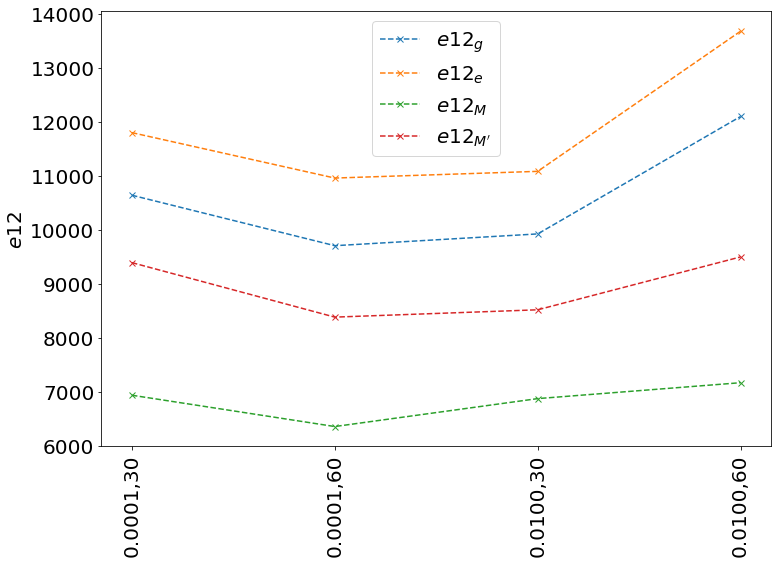

In [57]:
plot(x=x, y=e1_2s, ylabel=r"$e12$",
     labels=[r"$e12_g$", r"$e12_e$", r"$e12_{M}$", r"$e12_{M^\prime}$"],
     xticks=params_list, title=r"$Error 1 in main iteration 2$")

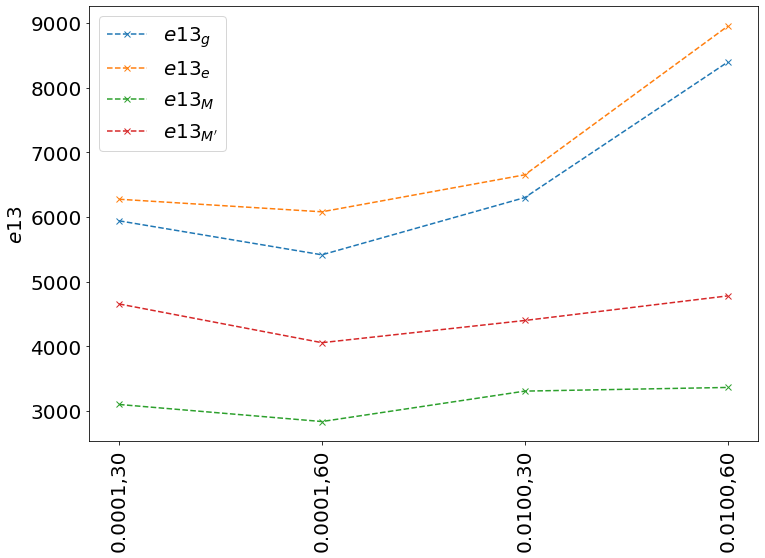

In [58]:
plot(x=x, y=e1_3s, ylabel=r"$e13$",
     labels=[r"$e13_g$", r"$e13_e$", r"$e13_{M}$", r"$e13_{M^\prime}$"],
     xticks=params_list, title=r"$Error 1 in main iteration 3$")

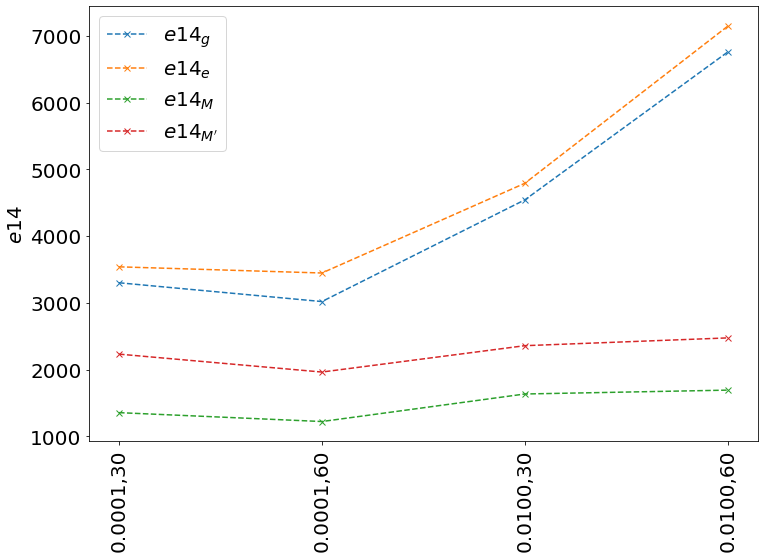

In [59]:
plot(x=x, y=e1_4s, ylabel=r"$e14$",
     labels=[r"$e14_g$", r"$e14_e$", r"$e14_{M}$", r"$e14_{M^\prime}$"],
     xticks=params_list, title=r"$Error 1 in main iteration 4$")

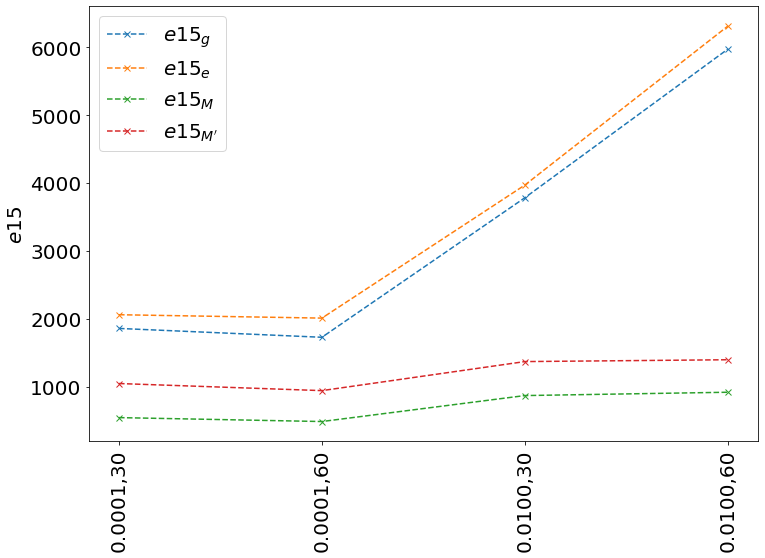

In [60]:
plot(x=x, y=e1_5s, ylabel=r"$e15$",
     labels=[r"$e15_g$", r"$e15_e$", r"$e15_{M}$", r"$e15_{M^\prime}$"],
     xticks=params_list, title=r"$Error 1 in main iteration 5$")

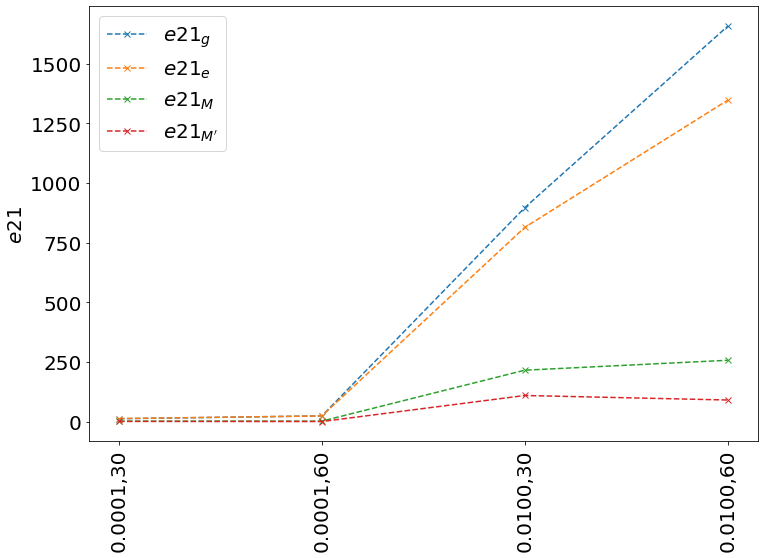

In [61]:
plot(x=x, y=e2_1s, ylabel=r"$e21$",
     labels=[r"$e21_g$", r"$e21_e$", r"$e21_{M}$", r"$e21_{M^\prime}$"],
     xticks=params_list, title=r"$Error 2 in main iteration 1$")

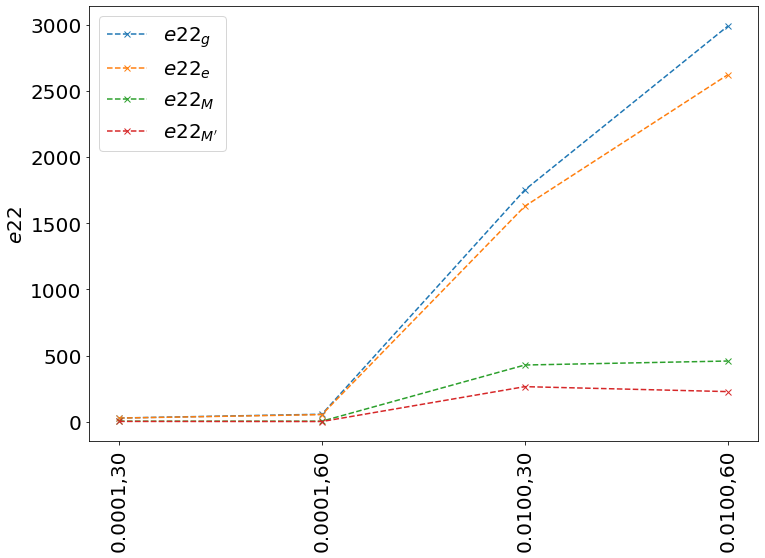

In [62]:
plot(x=x, y=e2_2s, ylabel=r"$e22$",
     labels=[r"$e22_g$", r"$e22_e$", r"$e22_{M}$", r"$e22_{M^\prime}$"],
     xticks=params_list, title=r"$Error 2 in main iteration 2$")

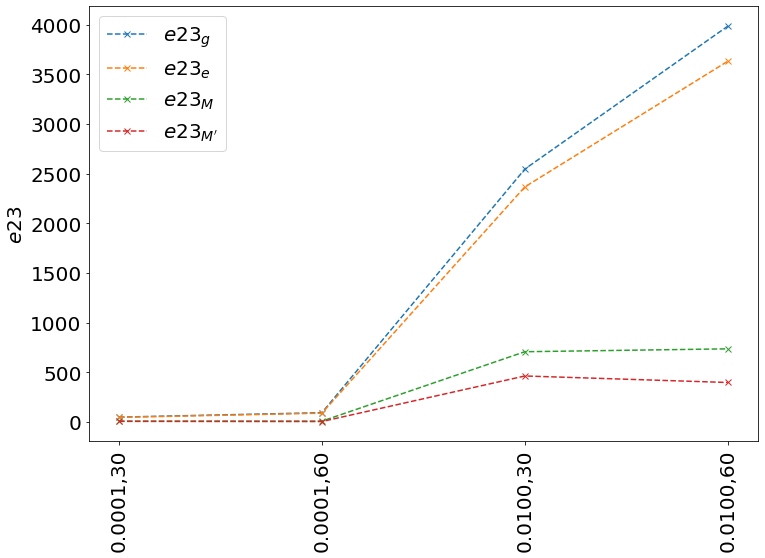

In [63]:
plot(x=x, y=e2_3s, ylabel=r"$e23$",
     labels=[r"$e23_g$", r"$e23_e$", r"$e23_{M}$", r"$e23_{M^\prime}$"],
     xticks=params_list, title=r"$Error 2 in main iteration 3$")

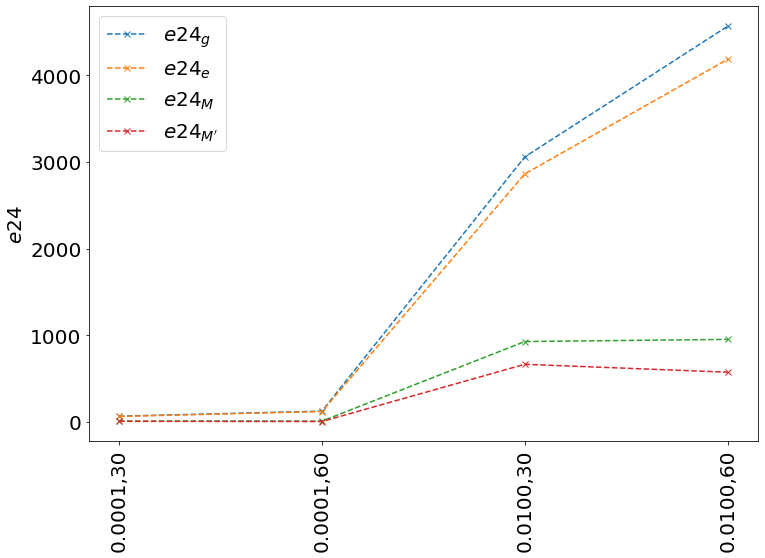

In [64]:
plot(x=x, y=e2_4s, ylabel=r"$e24$",
     labels=[r"$e24_g$", r"$e24_e$", r"$e24_{M}$", r"$e24_{M^\prime}$"],
     xticks=params_list, title=r"$Error 2 in main iteration 4$")

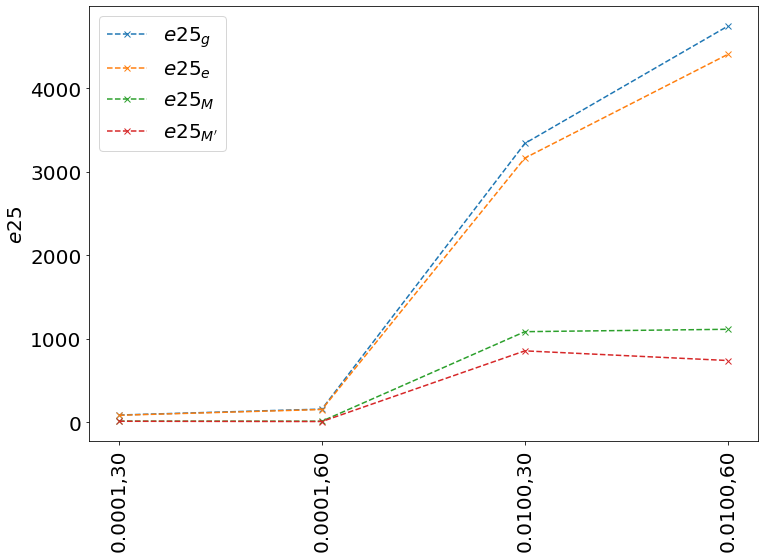

In [65]:
plot(x=x, y=e2_5s, ylabel=r"$e25$",
     labels=[r"$e25_g$", r"$e25_e$", r"$e25_{M}$", r"$e25_{M^\prime}$"],
     xticks=params_list, title=r"$Error 2 in main iteration 5$")